In [1]:
!pip install cirq

In [ ]:
import cirq
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize

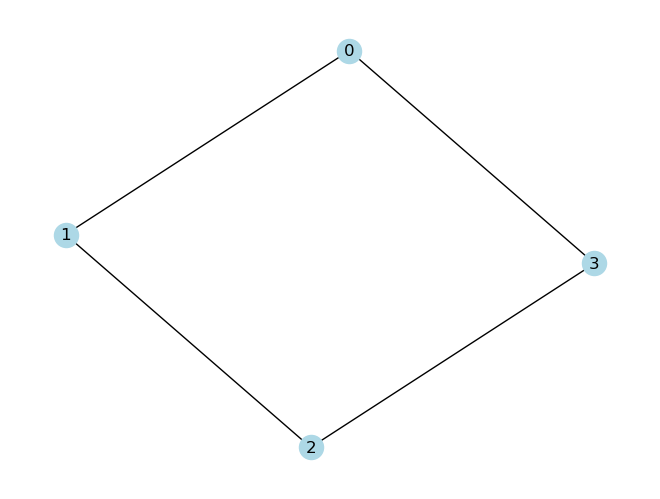

Parámetros óptimos: [1.98865825 2.66271945]
Valor final del costo: 2.931640625


In [2]:
# --- Definir grafo ---
graph = nx.Graph([(0,1),(1,2),(2,3),(3,0)])
nx.draw(graph, with_labels=True, node_color='lightblue')
plt.show()

# --- Crear qubits ---
qubits = [cirq.GridQubit(0,i) for i in range(len(graph.nodes))]

# --- Construir circuito QAOA ---
def qaoa_circuit(params):
    gamma, beta = params
    circuit = cirq.Circuit()

    # Estado inicial
    circuit.append([cirq.H(q) for q in qubits])

    # Capa de costo (ZZ rotations)
    for i,j in graph.edges:
        circuit.append(cirq.CNOT(qubits[i], qubits[j]))
        circuit.append(cirq.rz(2*gamma).on(qubits[j]))
        circuit.append(cirq.CNOT(qubits[i], qubits[j]))

    # Capa de mixer (X rotations)
    for q in qubits:
        circuit.append(cirq.rx(2*beta).on(q))

    # Medición
    circuit.append([cirq.measure(q) for q in qubits])
    return circuit

# --- Función de costo ---
simulator = cirq.Simulator()

def cost_function(params):
    circuit = qaoa_circuit(params)
    result = simulator.run(circuit, repetitions=1024)
    cost = 0
    for i in range(1024):
        bits = [int(result.measurements[str(q)][i][0]) for q in qubits]  # <- fix
        z = np.array([1 if b==0 else -1 for b in bits])
        s = sum(0.5*(1 - z[i]*z[j]) for i,j in graph.edges)
        cost += s
    return -cost/1024

# --- Optimización ---
np.random.seed(42)
params0 = np.random.uniform(0, np.pi, 2)
result = minimize(cost_function, params0, method='COBYLA')

# --- Resultados ---
print("Parámetros óptimos:", result.x)
print("Valor final del costo:", -result.fun)
